## Import Libraries and Install Packages

In [1]:
!pip install seaborn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import os
import h5py
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold

## Load Data

In [3]:
IMG_DIR = "/tf/notebooks/hezo/stroke_zurich/data/" 
# IMG_DIR2 = "/tf/notebooks/kook/data-sets/stroke-lh/"
OUTPUT_DIR = "/tf/notebooks/brdd/xAI_3d/data/"

In [4]:
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'

with h5py.File(path_img, "r") as h5:
# with h5py.File(IMG_DIR2 + 'dicom-3d.h5', "r") as h5:
# both images are the same
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

X_in = np.expand_dims(X_in, axis = 4)

print("image shape in: ", X_in.shape)
print("image min, max, mean, std: ", X_in.min(), X_in.max(), X_in.mean(), X_in.std())


## read tabular data
dat = pd.read_csv(path_tab, sep=",")

print("tabular shape in: ", dat.shape)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)


In [5]:
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], X_in.shape[4]))
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
p_id = p_id.astype("int")
        
print("X img out shape: ", X.shape)
print("X tab out shape: ", X_tab.shape)
print("Y mrs out shape: ", Y_mrs.shape)

X img out shape:  (407, 128, 128, 28, 1)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)


In [6]:
## all mrs <= 2 are favorable all higher unfavorable
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

<AxesSubplot:ylabel='count'>

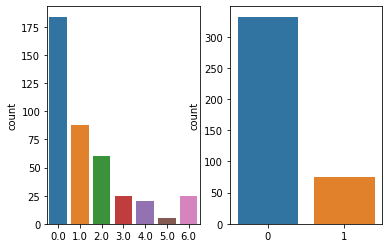

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2)
sns.countplot(x = Y_mrs, ax = ax1)
sns.countplot(x = Y_new, ax = ax2)

In [8]:
# Safe ids in pd
id_tab = pd.DataFrame(
    {"p_idx": range(1, len(p_id)+1),
     "p_id": p_id,
     "mrs": Y_mrs,
     "unfavorable": Y_new
    }
)

## Define Splits

In [9]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)
folds = []
  
for train_index, test_index in skf.split(p_id, Y_new):
    folds.append(p_id[test_index])
    print(sum(Y_new[test_index]))

7
7
8
8
8
8
8
7
7
7


In [10]:
for fold in folds:
    print(len(fold))

41
41
41
41
41
41
41
40
40
40


In [11]:
for i, fold in enumerate(folds):
    id_tab["fold" + str(i)] = "train" 
    
    # increment for val (+5 so that not twice has only 40 in train & test)
    j = i+5
    if j >= len(folds):
        j = j-10

    id_tab.loc[id_tab["p_id"].isin(fold), "fold"+str(i)] = "test"
    id_tab.loc[id_tab["p_id"].isin(folds[j]), "fold"+str(i)] = "val"

In [12]:
id_tab

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9
0,1,1,1.0,0,val,train,train,train,train,test,train,train,train,train
1,2,2,1.0,0,val,train,train,train,train,test,train,train,train,train
2,3,3,0.0,0,train,train,train,train,val,train,train,train,train,test
3,4,5,0.0,0,train,test,train,train,train,train,val,train,train,train
4,5,6,3.0,1,train,val,train,train,train,train,test,train,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,403,555,0.0,0,train,test,train,train,train,train,val,train,train,train
403,404,556,0.0,0,train,train,test,train,train,train,train,val,train,train
404,405,557,1.0,0,train,train,train,train,val,train,train,train,train,test
405,406,559,1.0,0,train,train,train,val,train,train,train,train,test,train


In [13]:
for i in range(len(folds)):
    print(id_tab["fold"+str(i)].value_counts())

train    325
val       41
test      41
Name: fold0, dtype: int64
train    325
val       41
test      41
Name: fold1, dtype: int64
train    326
test      41
val       40
Name: fold2, dtype: int64
train    326
test      41
val       40
Name: fold3, dtype: int64
train    326
test      41
val       40
Name: fold4, dtype: int64
train    325
val       41
test      41
Name: fold5, dtype: int64
train    325
val       41
test      41
Name: fold6, dtype: int64
train    326
val       41
test      40
Name: fold7, dtype: int64
train    326
val       41
test      40
Name: fold8, dtype: int64
train    326
val       41
test      40
Name: fold9, dtype: int64


## Save Data

In [14]:
id_tab.to_csv(OUTPUT_DIR + "10Fold_ids.csv",  index=False)

In [15]:
X = X.squeeze()
X = np.float32(X)

np.save(OUTPUT_DIR + "prepocessed_dicom_3d.npy", X)

## Analyze Data

In [16]:
id_tab = pd.read_csv(OUTPUT_DIR + "10Fold_ids.csv", sep=",")
X = np.load(OUTPUT_DIR + "prepocessed_dicom_3d.npy")

In [17]:
id_tab["unfavorable"].value_counts()

0    332
1     75
Name: unfavorable, dtype: int64

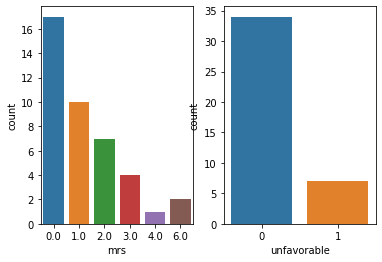

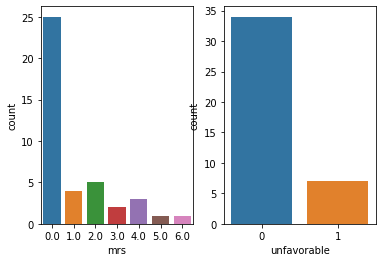

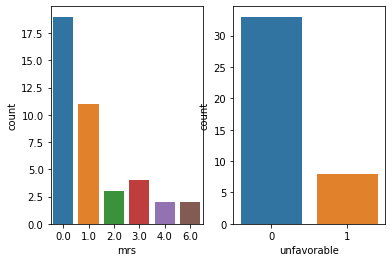

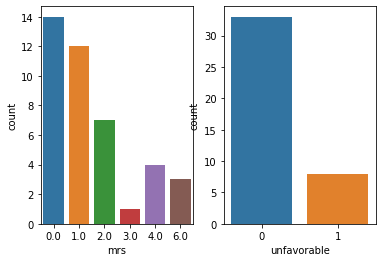

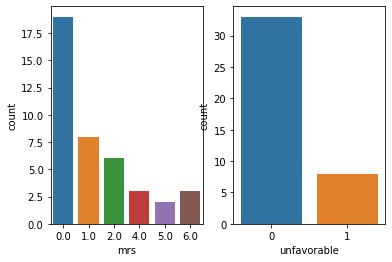

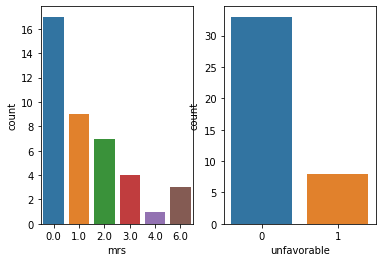

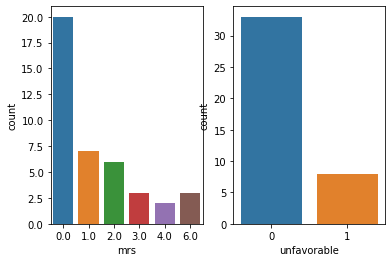

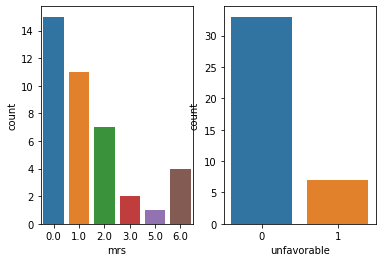

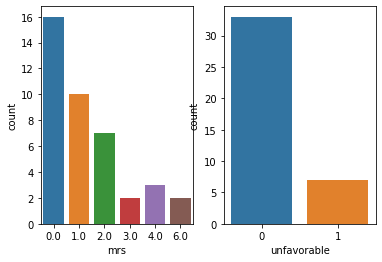

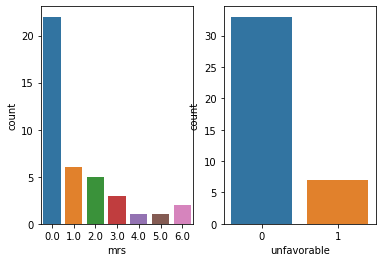

In [18]:
for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1,2)
    sns.countplot(x = id_tab[id_tab["fold"+str(i)]=="test"].mrs, ax = ax1)
    sns.countplot(x = id_tab[id_tab["fold"+str(i)]=="test"].unfavorable, ax = ax2)

### Check Images

Check if images are the same when accessing them.

In [19]:
patient = 460
index1 = id_tab[id_tab.p_id == patient].index
print(index1)
index2 = np.argwhere(pat == patient).squeeze()
print(index2)

Int64Index([323], dtype='int64')
346


In [20]:
im1 = X[index1].astype("float64")
im2 = X_in.squeeze()[index2].astype("float64")
np.allclose(im1, im2)

True